In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dream5 dataset
Please download the following datasets from the [dream5 dedicated website] (you need to create an account first)(https://www.synapse.org/#!Synapse:syn3130840):


+ `net3_expression_data.tsv`: E. coli gene expression data (MicroArray)
+ `net3_transcription_factors.tsv`: transcription factor genes

### Load the datasets
+ Load the gene expression dataset $X$

In [3]:
X = pd.read_csv("net3_expression_data.tsv",sep="\t").T# rows represent genes and columns represent conditions

+ Load the Transcription Factors list

In [4]:
tf = pd.read_csv("net3_transcription_factors.tsv",header=None)[0]

# Preprocessing

Apply a simple z-score gene-wise (axis=0)

In [5]:
from grenadine.Preprocessing.standard_preprocessing import z_score
from grenadine.Preprocessing.discretization import discretize_genexp

In [6]:
#X = z_score(X,axis=0)

In [7]:
X = discretize_genexp(data=X,method="efd",nb_bins=5,axis=1)

# Infer the GRN
+ Load the score links function and SVM classification method

In [8]:
from grenadine.Inference.inference import score_links
from grenadine.Inference.classification_predictors import ComplementNB_classifier_score

/Users/sergiopeignier/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


+ Choose the parameters of the underlying Complement Bayes method

(the parameters are the same as those of [sklearn SVC](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html))

In [9]:
ComplementNB_params = {}

+ Score all the possible edges between Transcription Factors and Target Genes

In [10]:
score_matrix = score_links(gene_expression_matrix=X,
                           score_predictor=ComplementNB_classifier_score,
                           tf_list=tf,
                           **ComplementNB_params)

# Visualize the results

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

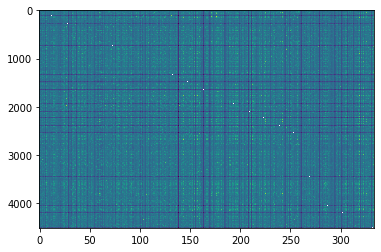

In [12]:
plt.imshow(score_matrix,aspect="auto")

# Rank the links according to their scores

In [13]:
from grenadine.Inference.inference import rank_GRN
ranking = rank_GRN(score_matrix)

In [14]:
ranking.head(10)

,rank,score,TF,TG
G139_G2155,1.0,5.825416,G139,G2155
G23_G992,2.0,5.825284,G23,G992
G293_G676,3.0,5.825164,G293,G676
G194_G1339,4.0,5.825114,G194,G1339
G259_G3162,5.0,5.825031,G259,G3162
G259_G2929,6.0,5.824860,G259,G2929
G194_G3385,7.0,5.824507,G194,G3385
G318_G4489,8.0,5.824462,G318,G4489
G259_G4271,9.0,5.824409,G259,G4271
G259_G2314,10.0,5.824357,G259,G2314


# Evalute the Results
+ Download `DREAM5_NetworkInference_GoldStandard_Network3 - E. coli.tsv` the gold standard dataset from the [dream5 website](https://www.synapse.org/#!Synapse:syn2787213)
+ Load the gold standard

In [15]:
grn = pd.read_csv("DREAM5_NetworkInference_GoldStandard_Network3 - E. coli.tsv",sep="\t",header=None)
# Rename the columns and the index
grn.columns = ["TF","TG","IS_REGULATED"]
grn.index = grn["TF"]+"_"+grn["TG"]
# Drop duplicate rows
grn = grn.drop_duplicates()

+ Load the `evaluate_result` function 

In [16]:
from grenadine.Evaluation.evaluation import evaluate_result

In [17]:
metrics = evaluate_result(score_matrix, grn, n_links=100000)

In [18]:
metrics

AUROC        0.756187
AUPR         0.334301
Precision    0.107988
Recall       0.661631
Accuracy     0.743456
F1           0.185672
dtype: float64